In [3]:
import tensorflow as tf
import keras

device = "cuda" if tf.config.list_physical_devices("GPU") else "cpu"

# Set memory growth for GPU
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-07-01 09:35:36.755803: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-01 09:35:36.870019: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751355336.918201 1049441 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751355336.932814 1049441 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-01 09:35:37.042021: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Chargement des données

In [4]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    "../../../data/OpenAnimalTracks/cropped_imgs/train",
    image_size=(224, 224),
    batch_size=16,
    shuffle=True,
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    "../../../data/OpenAnimalTracks/cropped_imgs/val",
    image_size=(224, 224),
    batch_size=16,
    shuffle=False,
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    "../../../data/OpenAnimalTracks/cropped_imgs/test",
    image_size=(224, 224),
    batch_size=16,
    shuffle=False,
)

Found 2514 files belonging to 18 classes.


I0000 00:00:1751355338.520146 1049441 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20945 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 346 files belonging to 18 classes.
Found 719 files belonging to 18 classes.


In [5]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.05),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
])

In [6]:
mobilenet_model = keras.applications.MobileNetV3Small(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

In [7]:
mobilenet_model.trainable = False

In [8]:
model = keras.Sequential([
    data_augmentation,
    mobilenet_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.02)),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.02)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(18, activation="softmax"),
])

In [9]:
model.compile(
    optimizer=keras.optimizers.Adamax(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [10]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,120 (3.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 939,120 (3.58 MB)

In [11]:
history = model.fit(
    train_ds,
    epochs=80,
    validation_data=val_ds
)

Epoch 1/80


I0000 00:00:1751355344.548727 1049883 cuda_dnn.cc:529] Loaded cuDNN version 90300


158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.0830 - loss: 18.2854 - val_accuracy: 0.2832 - val_loss: 14.3448
Epoch 2/80
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1941 - loss: 13.9385 - val_accuracy: 0.3468 - val_loss: 12.0513
Epoch 3/80
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2387 - loss: 11.8210 - val_accuracy: 0.3468 - val_loss: 10.4513
Epoch 4/80
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2865 - loss: 10.2564 - val_accuracy: 0.3671 - val_loss: 9.2075
Epoch 5/80
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2988 - loss: 9.0750 - val_accuracy: 0.3844 - val_loss: 8.2241
Epoch 6/80
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3402 - loss: 8.0583 - val_accuracy: 0.3699 - val_loss: 7.3885
Epoch 7/80
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3610 - loss: 7.2312 - val_accuracy: 0.3526 - val_loss: 6.7255
Epoch 8/80
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3832 - loss: 6.5156 - val_accuracy: 0.398

In [12]:
model.save("mobilenet_model.keras")

In [13]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    "../../../data/dataset_no_oat_downsample_splited/train",
    image_size=(224, 224),
    batch_size=16,
    shuffle=True,
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    "../../../data/dataset_no_oat_downsample_splited/val",
    image_size=(224, 224),
    batch_size=16,
    shuffle=False,
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    "../../../data/dataset_no_oat_downsample_splited/test",
    image_size=(224, 224),
    batch_size=16,
    shuffle=False,
)

Found 767 files belonging to 13 classes.


Found 221 files belonging to 13 classes.
Found 117 files belonging to 13 classes.


In [14]:
loaded_model = keras.models.load_model("mobilenet_model.keras")

mobilenet_base = loaded_model.layers[1]

mobilenet_base.trainable = True

for layer in mobilenet_base.layers[:-50]:
    layer.trainable = False

In [15]:
fine_tune_model = keras.Sequential([
    loaded_model.layers[0],
    mobilenet_base,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.02)),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.02)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(13, activation="softmax")
])

In [16]:
for i in range(2, len(loaded_model.layers) - 1):
    fine_tune_model.layers[i].set_weights(loaded_model.layers[i].get_weights())

In [17]:
fine_tune_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [18]:
history2 = fine_tune_model.fit(
    train_ds,
    epochs=150,
    validation_data=val_ds
)

Epoch 1/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.0806 - loss: 3.2451 - val_accuracy: 0.0860 - val_loss: 3.1199
Epoch 2/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1179 - loss: 3.0721 - val_accuracy: 0.1403 - val_loss: 2.9966
Epoch 3/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1190 - loss: 2.9790 - val_accuracy: 0.1584 - val_loss: 2.9380
Epoch 4/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1593 - loss: 2.8754 - val_accuracy: 0.1674 - val_loss: 2.8909
Epoch 5/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1731 - loss: 2.8100 - val_accuracy: 0.1900 - val_loss: 2.8491
Epoch 6/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2280 - loss: 2.7251 - val_accuracy: 0.1946 - val_loss: 2.8297
Epoch 7/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2586 - loss: 2.6338 - val_accuracy: 0.1900 - val_loss: 2.8215
Epoch 8/150
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2485 - loss: 2.6237 - val_accuracy: 0.

In [19]:
test_loss, test_acc = fine_tune_model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.2%}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0700 - loss: 4.4784.59
Test accuracy: 10.26%


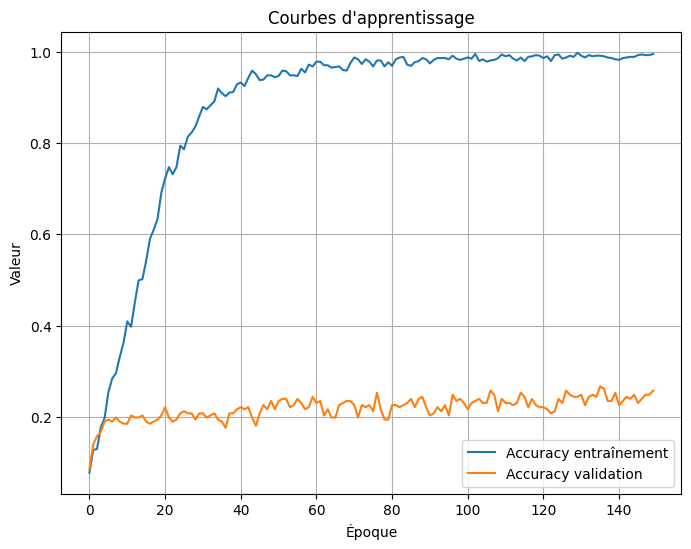

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Accuracy
plt.plot(history2.history['accuracy'], label='Accuracy entraînement')
plt.plot(history2.history['val_accuracy'], label='Accuracy validation')

plt.title("Courbes d'apprentissage")
plt.xlabel("Époque")
plt.ylabel("Valeur")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [22]:
y_pred = fine_tune_model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


In [23]:
y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

2025-07-01 09:38:46.573743: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
class_names = test_ds.class_names

In [25]:
cm = confusion_matrix(y_true, y_pred_classes)

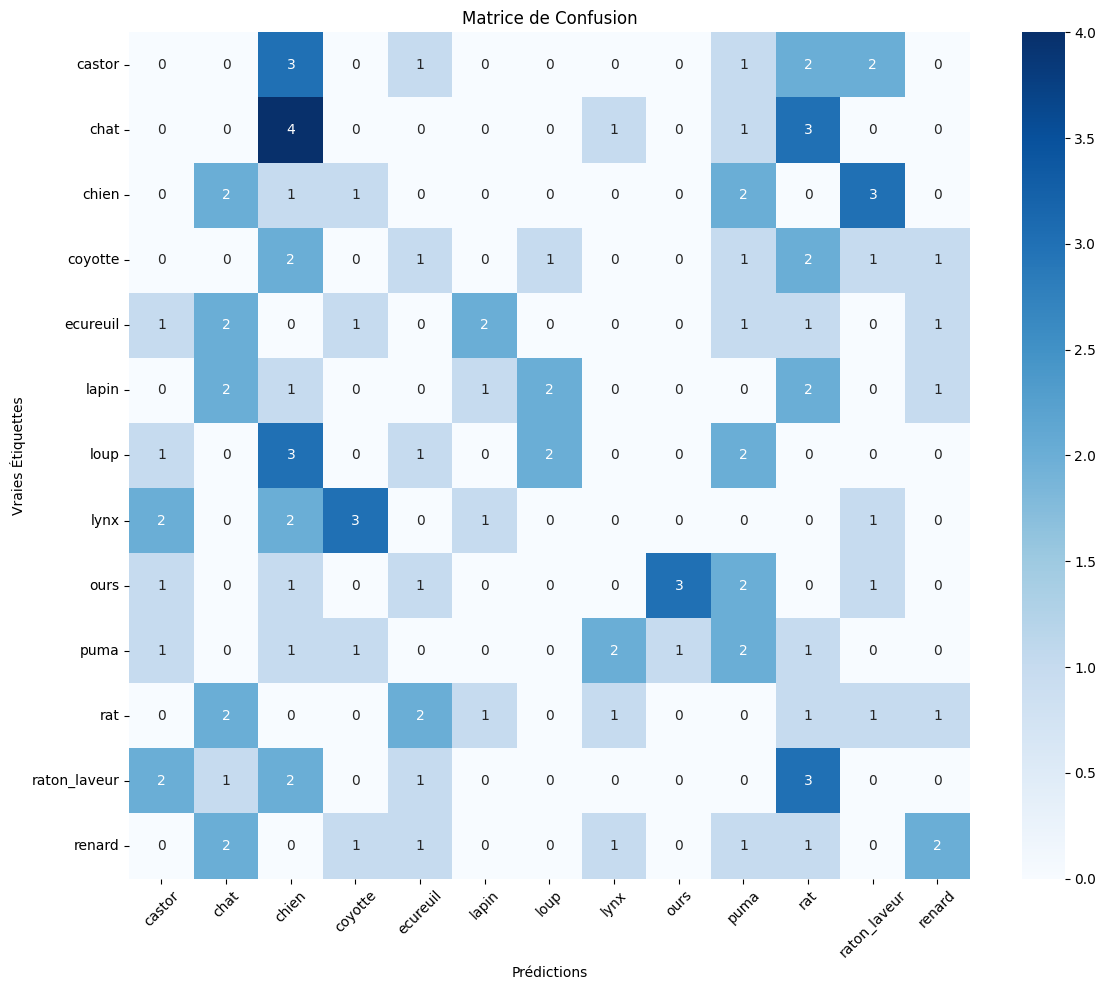

In [26]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies Étiquettes')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()